In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import seaborn as sns
import random
import pathlib

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet169

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/dataset-original.zip" -d "/content/drive/MyDrive"

In [3]:
strategy = tf.distribute.MirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [4]:
base_dir = '/content/drive/MyDrive/trash_dataset'
dataset = pathlib.Path(base_dir)
print(str(dataset))

/content/drive/MyDrive/trash_dataset


In [5]:
train_dir = str(dataset) + '/train'
test_dir = str(dataset) + '/test'
data_train = pathlib.Path(train_dir)
data_test = pathlib.Path(test_dir)

print(str(data_train))
print(str(data_test))

/content/drive/MyDrive/trash_dataset/train
/content/drive/MyDrive/trash_dataset/test


In [6]:
class_names = np.array(tf.io.gfile.listdir(str(data_train)))
class_names = class_names[class_names != '.DS_Store']
print(class_names)

['paper' 'metal' 'plastic' 'glass' 'trash' 'cardboard']


In [7]:
batch_size = 32
img_height = 224
img_width = 224

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.
Using 2160 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.
Using 540 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [11]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)


In [12]:
def get_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [img_height, img_width])
  return img

In [13]:
def get_img_and_label(file_path):
  label = get_label(file_path)
  img = get_image(file_path)
  return img, label

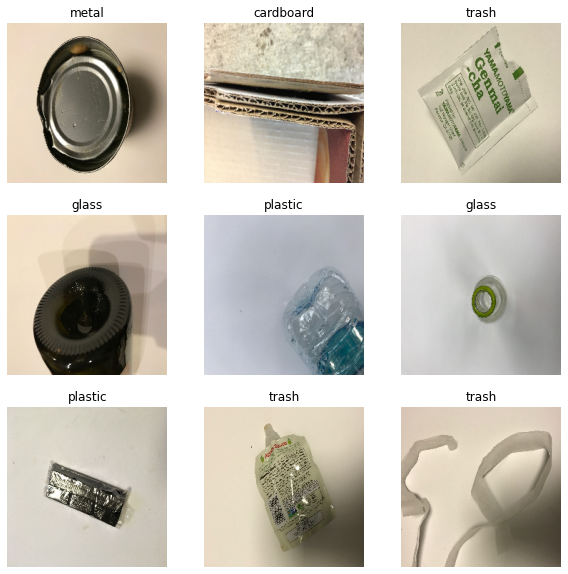

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1)
  ]
)

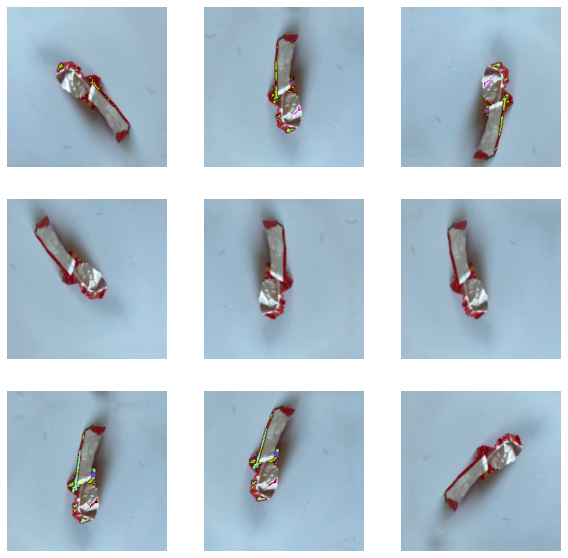

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
def pre_process(image_files):
  files_ds = tf.data.Dataset.from_tensor_slices(image_files)
  image_ds = files_ds.map(map_func=get_img_and_label, num_parallel_calls=AUTOTUNE)
  return image_ds

In [16]:
num_classes = len(class_names)
print(num_classes)

6


In [ ]:
with strategy.scope():
  inputs = layers.Input(shape=(img_height, img_width, 3))
  x = data_augmentation(inputs)
  x = tf.keras.applications.densenet.preprocess_input(x, data_format=None)
  outputs = DenseNet169(include_top=True, weights=None, classes=num_classes)(x)
  model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                           

In [ ]:
epochs = 100
hist = model.fit(train_ds, 
                 epochs=epochs, 
                 validation_data=val_ds)

Epoch 1/100
68/68 [==============================] - 129s 1s/step - loss: 1.4693 - accuracy: 0.4542 - val_loss: 7.4936 - val_accuracy: 0.2037
Epoch 2/100
68/68 [==============================] - 70s 1s/step - loss: 1.2728 - accuracy: 0.5245 - val_loss: 1.9551 - val_accuracy: 0.3648
Epoch 3/100
68/68 [==============================] - 69s 1s/step - loss: 1.2062 - accuracy: 0.5537 - val_loss: 3.1762 - val_accuracy: 0.3148
Epoch 4/100
68/68 [==============================] - 70s 1s/step - loss: 1.1257 - accuracy: 0.5759 - val_loss: 2.3383 - val_accuracy: 0.3685
Epoch 5/100
68/68 [==============================] - 70s 1s/step - loss: 1.0207 - accuracy: 0.6370 - val_loss: 1.9949 - val_accuracy: 0.4278
Epoch 6/100
68/68 [==============================] - 69s 1s/step - loss: 1.0344 - accuracy: 0.6370 - val_loss: 3.6862 - val_accuracy: 0.3630
Epoch 7/100
68/68 [==============================] - 69s 1s/step - loss: 0.9918 - accuracy: 0.6412 - val_loss: 3.3513 - val_accuracy: 0.3352
Epoch 8/100


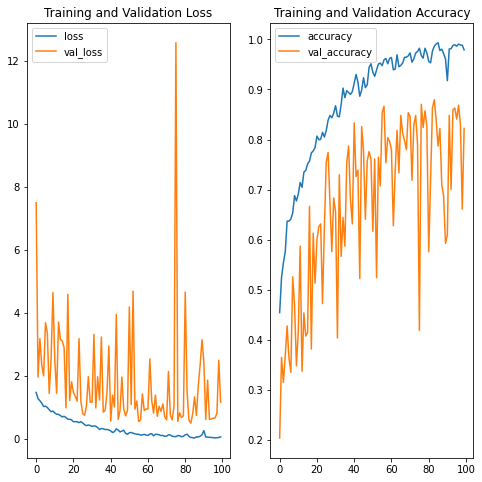

In [ ]:
metrics = hist.history
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(hist.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Training and Validation Loss')
plt.subplot(1, 2, 2)
plt.plot(hist.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.show()

In [17]:
test_files = filenames = tf.io.gfile.glob(str(data_test) + '/*/*.jpg')
test_ds = pre_process(test_files)

In [18]:
test_images = []
test_labels = []

for image, label in test_ds:
  test_images.append(image.numpy())
  test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [19]:
model_densenet = tf.keras.models.load_model('/content/drive/MyDrive/DenseNet169.h5')

In [ ]:
loss, acc = model_densenet.evaluate(test_images, test_labels)
print('Restored model, accuracy: {:5.0f}%'.format(100 * acc))

20/20 [==============================] - 120s 6s/step - loss: 1.5583 - accuracy: 0.7651
Restored model, accuracy:    77%


In [20]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model_densenet.predict(test_images), axis=1)
y_true = test_labels

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.76      0.90      0.82       101
       glass       0.83      0.72      0.77       125
       metal       0.76      0.68      0.72       102
       paper       0.86      0.80      0.83       148
     plastic       0.78      0.79      0.79       120
       trash       0.37      0.56      0.45        34

    accuracy                           0.77       630
   macro avg       0.73      0.74      0.73       630
weighted avg       0.78      0.77      0.77       630



In [21]:
import sklearn.metrics as skm

cm = skm.multilabel_confusion_matrix(y_true, y_pred)
print(cm)

[[[500  29]
  [ 10  91]]

 [[487  18]
  [ 35  90]]

 [[506  22]
  [ 33  69]]

 [[462  20]
  [ 30 118]]

 [[483  27]
  [ 25  95]]

 [[564  32]
  [ 15  19]]]


In [ ]:
y_pred = np.argmax(model.predict(test_images), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 77%


In [ ]:
model.save('/content/drive/MyDrive/DenseNet169.h5')

In [ ]:
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file( 'model.h5')
tfmodel = converter.convert()
open ("model.tflite" , "wb") .write(tfmodel)

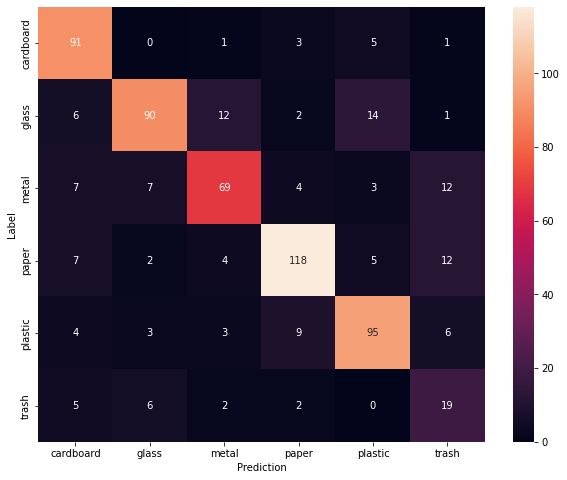

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()